## Setup


In this first cell we''ll load the necessary libraries and setup some logging and display options.

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

Next we'll load our flow variables and time tendency forcings datasets into Xarray Dataset objects.

In [2]:
ds_h0 = xr.open_dataset('C:/home/cam_learn/fv091x180L26_dry_HS.cam.h0.2000-12-27-00000_lowres.nc', decode_times=False)
ds_h1 = xr.open_dataset('C:/home/cam_learn/fv091x180L26_dry_HS.cam.h1.2000-12-27-00000_lowres.nc', decode_times=False)

In [3]:
ds_h0.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:       (ilev: 27, lat: 12, lev: 26, lon: 23, nbnd: 2, slat: 90, slon: 180, time: 720)
Coordinates:
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 29.84 44.62 61.61 ...
  * lat           (lat) float64 -90.0 -74.0 -58.0 -42.0 -26.0 -10.0 6.0 22.0 ...
  * lev           (lev) float64 3.545 7.389 13.97 23.94 37.23 53.11 70.06 ...
  * lon           (lon) float64 0.0 16.0 32.0 48.0 64.0 80.0 96.0 112.0 ...
  * slat          (slat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 -79.0 -77.0 ...
  * slon          (slon) float64 -1.0 1.0 3.0 5.0 7.0 9.0 11.0 13.0 15.0 ...
  * time          (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042 ...
Dimensions without coordinates: nbnd
Data variables:
    P0            float64 ...
    PS            (time, lat, lon) float32 ...
    T             (time, lev, lat, lon) float32 ...
    U             (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
    ch4v

In [4]:
ds_h1.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:       (ilev: 27, lat: 12, lev: 26, lon: 23, nbnd: 2, slat: 90, slon: 180, time: 720)
Coordinates:
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 29.84 44.62 61.61 ...
  * lat           (lat) float64 -90.0 -74.0 -58.0 -42.0 -26.0 -10.0 6.0 22.0 ...
  * lev           (lev) float64 3.545 7.389 13.97 23.94 37.23 53.11 70.06 ...
  * lon           (lon) float64 0.0 16.0 32.0 48.0 64.0 80.0 96.0 112.0 ...
  * slat          (slat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 -79.0 -77.0 ...
  * slon          (slon) float64 -1.0 1.0 3.0 5.0 7.0 9.0 11.0 13.0 15.0 ...
  * time          (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042 ...
Dimensions without coordinates: nbnd
Data variables:
    P0            float64 ...
    PTTEND        (time, lev, lat, lon) float32 ...
    PUTEND        (time, lev, lat, lon) float32 ...
    PVTEND        (time, lev, lat, lon) float32 ...
    ch4vmr        (time) float64 ...
    co2vmr        

Look at the time variable in order to work out the initial date, number of steps, units, etc.

In [52]:
ds_h0.variables['time']

<xarray.IndexVariable 'time' (time: 720)>
array([ 0.      ,  0.020833,  0.041667, ..., 14.9375  , 14.958333, 14.979167])
Attributes:
    long_name:  time
    units:      days since 2000-12-27 00:00:00
    calendar:   noleap
    bounds:     time_bnds

Make sure we have the same time values for the targets data.

In [53]:
if (ds_h0.variables['time'].values != ds_h1.variables['time'].values).any():
    print('ERROR: Non-matching time values')

Create array of datetime values from the times.

In [9]:
from datetime import datetime, timedelta
times = ds_h0.variables['time'].values.flatten()
initial = datetime(2000, 12, 27)
datetimes = np.empty(shape=times.shape, dtype='datetime64[m]')
for i in range(datetimes.size):
    datetimes[i] = initial + timedelta(days=times[i])
timestamps = pd.Series(datetimes)
timestamps.head()

0   2000-12-27 00:00:00
1   2000-12-27 00:30:00
2   2000-12-27 01:00:00
3   2000-12-27 01:30:00
4   2000-12-27 02:00:00
dtype: datetime64[ns]

## Feature and target selection

As features we'll use the following flow variables:

* U (west-east (zonal) wind, m/s)
* V (south-north (meridional) wind, m/s)
* T (temperature, K)
* PS (surface pressure, Pa)

Time tendency forcings are the targets (labels) that our model should learn to predict.

* PTTEND (time tendency of the temperature)
* PUTEND (time tendency of the zonal wind)
* PVTEND (time tendency of the meridional wind)

Eventually we'll train/fit our model for an entire global 3-D grid, but for this example we'll select a single lat/lon/lev location, getting all time steps for the feature and target variables at the lat/lon/lev location.

In [10]:
ps = pd.Series(ds_h0.variables['PS'].values[:, 0, 0])
t = pd.Series(ds_h0.variables['T'].values[:, 0, 0, 0])
u = pd.Series(ds_h0.variables['U'].values[:, 0, 0, 0])
v = pd.Series(ds_h0.variables['V'].values[:, 0, 0, 0])
pttend = pd.Series(ds_h1.variables['PTTEND'].values[:, 0, 0, 0])
putend = pd.Series(ds_h1.variables['PUTEND'].values[:, 0, 0, 0])
pvtend = pd.Series(ds_h1.variables['PVTEND'].values[:, 0, 0, 0])

Convert to a Pandas DataFrame containing inputs (features) and output (label/target) for use when predicting time tendency forcings.

In [11]:
df_vals = pd.DataFrame({'timestamp': timestamps,
                        'PS': ps,
                        'T': t,
                        'U': u,
                        'V': v,
                        'PTTEND': pttend,
                        'PUTEND': putend,
                        'PVTEND': pvtend})
df_vals.set_index('timestamp', inplace=True)
df_vals.head()

,PS,T,U,V,PTTEND,PUTEND,PVTEND
timestamp,,,,,,,
2000-12-27 00:00:00,101099.062500,210.862564,-0.814972,-0.280670,-0.000003,0.0,0.0
2000-12-27 00:30:00,101108.921875,210.860840,-0.820554,-0.299137,-0.000003,0.0,0.0
2000-12-27 01:00:00,101118.484375,210.858978,-0.826019,-0.317353,-0.000003,0.0,0.0
2000-12-27 01:30:00,101127.906250,210.857178,-0.828459,-0.333411,-0.000003,0.0,0.0
2000-12-27 02:00:00,101137.390625,210.855576,-0.826649,-0.346365,-0.000003,0.0,0.0


In [12]:
df_vals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2000-12-27 00:00:00 to 2001-01-10 23:30:00
Data columns (total 7 columns):
PS        720 non-null float32
T         720 non-null float32
U         720 non-null float32
V         720 non-null float32
PTTEND    720 non-null float32
PUTEND    720 non-null float32
PVTEND    720 non-null float32
dtypes: float32(7)
memory usage: 25.3 KB


Normalize the feature variables using scikit-learn's [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_vals.values)
scaled

array([[0.50631714, 1.        , 0.22656655, ..., 0.        , 0.        ,
        0.        ],
       [0.5129471 , 0.9949341 , 0.22496124, ..., 0.00498581, 0.        ,
        0.        ],
       [0.51937866, 0.98950195, 0.2233897 , ..., 0.01043701, 0.        ,
        0.        ],
       ...,
       [0.12479401, 0.23565674, 0.98422444, ..., 0.76434326, 0.        ,
        0.        ],
       [0.12210846, 0.23876953, 0.98267317, ..., 0.76122856, 0.        ,
        0.        ],
       [0.11936951, 0.2397461 , 0.98426366, ..., 0.76023674, 0.        ,
        0.        ]], dtype=float32)

Normalize the feature variables using scikit-learn's MinMaxScaler.

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_temp.values)
scaled

array([[0.50631714, 1.        , 0.22656655, 0.69448346, 0.        ],
       [0.5129471 , 0.9949341 , 0.22496124, 0.68799436, 0.00498581],
       [0.51937866, 0.98950195, 0.2233897 , 0.6815935 , 0.01043701],
       ...,
       [0.12479401, 0.23565674, 0.98422444, 0.7495539 , 0.76434326],
       [0.12210846, 0.23876953, 0.98267317, 0.7519671 , 0.76122856],
       [0.11936951, 0.2397461 , 0.98426366, 0.7531688 , 0.76023674]],
      dtype=float32)

Replace the original columns with the scaled values.

In [14]:
for i in range(len(df_vals.columns)):
    s = pd.Series(scaled[:, i])
    df_vals[df_vals.columns[i]] = s.values
df_vals.head()

,PS,T,U,V,PTTEND,PUTEND,PVTEND
timestamp,,,,,,,
2000-12-27 00:00:00,0.506317,1.000000,0.226567,0.694483,0.000000,0.0,0.0
2000-12-27 00:30:00,0.512947,0.994934,0.224961,0.687994,0.004986,0.0,0.0
2000-12-27 01:00:00,0.519379,0.989502,0.223390,0.681593,0.010437,0.0,0.0
2000-12-27 01:30:00,0.525711,0.984192,0.222688,0.675951,0.015718,0.0,0.0
2000-12-27 02:00:00,0.532089,0.979492,0.223209,0.671399,0.020433,0.0,0.0


## Split the data into training and testing datasets

For simplicity we'll start with an even split of 50% for training and 50% for testing.

In [21]:
# the values array is 720 rows x 10 columns
train = df_vals.values[:360, :]   # rows 0 - 359
test = df_vals.values[360:, :]   # rows 360 - 719

# # split into input and outputs
# train_X, train_y = train[:, :-3], train[:, -3:]
# test_X, test_y = test[:, :-3], test[:, -3:]

# use final value of final column as target, until we work out how to predict multiple targets
train_X, train_y = train[:, :-3], train[-1:, -1:]
test_X, test_y = test[:, :-3], test[-1:, -1:]

# # convert shape of outputs from (360, 1) to (1, 360)
# # train_y = np.swapaxes(train_y, 0, 1)
# # test_y = np.swapaxes(test_y, 0, 1)
train_y = train_y.flatten()
test_y = test_y.flatten()

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((1, train_X.shape[0], train_X.shape[1]))
test_X = test_X.reshape((1, test_X.shape[0], test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1, 360, 4) (1,) (1, 360, 4) (1,)


## Create the LSTM recurrent neural network

Next, we'll instantiate and configure a Long Short-Term Memory (LSTM) recurrent neural network using Keras's [Sequential](https://keras.io/models/sequential/) class. We'll train this model using an Adam version of stochastic gradient descent, and use the Mean Absolute Error (MAE) loss function.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting the PVTEND target. The input shape will be 1 time step with 4 features.

In [22]:
import keras

# design network
model = keras.models.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

## Train and evaluate the model

The model will be fit for 50 training epochs with a batch size of 72.

Train on 1 samples, validate on 1 samples
Epoch 1/50
 - 1s - loss: 0.0667 - val_loss: 0.0676
Epoch 2/50
 - 0s - loss: 7.8451e-04 - val_loss: 0.0698
Epoch 3/50
 - 0s - loss: 0.0026 - val_loss: 0.0457
Epoch 4/50
 - 0s - loss: 0.0193 - val_loss: 0.0487
Epoch 5/50
 - 0s - loss: 0.0156 - val_loss: 0.0676
Epoch 6/50
 - 0s - loss: 0.0028 - val_loss: 0.0675
Epoch 7/50
 - 0s - loss: 0.0036 - val_loss: 0.0544
Epoch 8/50
 - 0s - loss: 0.0078 - val_loss: 0.0555
Epoch 9/50
 - 0s - loss: 0.0062 - val_loss: 0.0672
Epoch 10/50
 - 0s - loss: 0.0051 - val_loss: 0.0668
Epoch 11/50
 - 0s - loss: 0.0053 - val_loss: 0.0565
Epoch 12/50
 - 0s - loss: 0.0034 - val_loss: 0.0571
Epoch 13/50
 - 0s - loss: 0.0025 - val_loss: 0.0666
Epoch 14/50
 - 0s - loss: 0.0065 - val_loss: 0.0661
Epoch 15/50
 - 0s - loss: 0.0064 - val_loss: 0.0571
Epoch 16/50
 - 0s - loss: 0.0012 - val_loss: 0.0575
Epoch 17/50
 - 0s - loss: 4.7965e-04 - val_loss: 0.0659
Epoch 18/50
 - 0s - loss: 0.0073 - val_loss: 0.0653
Epoch 19/50
 - 0s - los

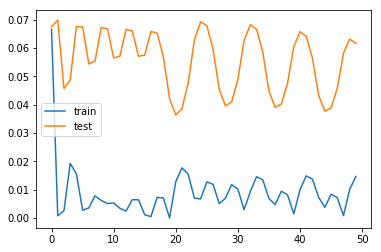

In [23]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()